In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [12]:
# Load dataset
data_url = 'https://raw.githubusercontent.com/LahiWeer/2330902-ML_CW/refs/heads/master/Preprocessing/resampled_and_original_data.csv'
data = pd.read_csv(data_url)

In [13]:
# Step 2: Separate features (X) and target (y)
X = data.drop('y', axis=1)
y = data['y']


# **Training the Neural Network Model**


In [14]:
# Step 3: List of columns to scale
columns_to_scale = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
                    'default', 'housing', 'loan', 'contact', 'month',
                    'day_of_week', 'poutcome', 'education']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Apply scaling only to specific columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the specified columns
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# Step 6: Initialize model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.0025)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and reduce learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 7: Hyperparameter tuning with Stratified K-Fold Cross Validation
history = []  # List to store history of training for plotting

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model and save the history
    fold_history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=700,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Store the history of each fold
    history.append(fold_history.history)

Epoch 1/700


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7678 - loss: 0.4841 - val_accuracy: 0.8393 - val_loss: 0.3684 - learning_rate: 0.0025
Epoch 2/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8415 - loss: 0.3732 - val_accuracy: 0.8473 - val_loss: 0.3496 - learning_rate: 0.0025
Epoch 3/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8473 - loss: 0.3539 - val_accuracy: 0.8514 - val_loss: 0.3549 - learning_rate: 0.0025
Epoch 4/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8496 - loss: 0.3519 - val_accuracy: 0.8485 - val_loss: 0.3500 - learning_rate: 0.0025
Epoch 5/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8530 - loss: 0.3464 - val_accuracy: 0.8513 - val_loss: 0.3405 - learning_rate: 0.0025
Epoch 6/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8530 - loss: 0.3451 - val_accuracy: 0.8549 - val_loss: 0.3381 - learning_rate: 0.0025
Epoch 7/700
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8541 - loss: 0.3389 - val_

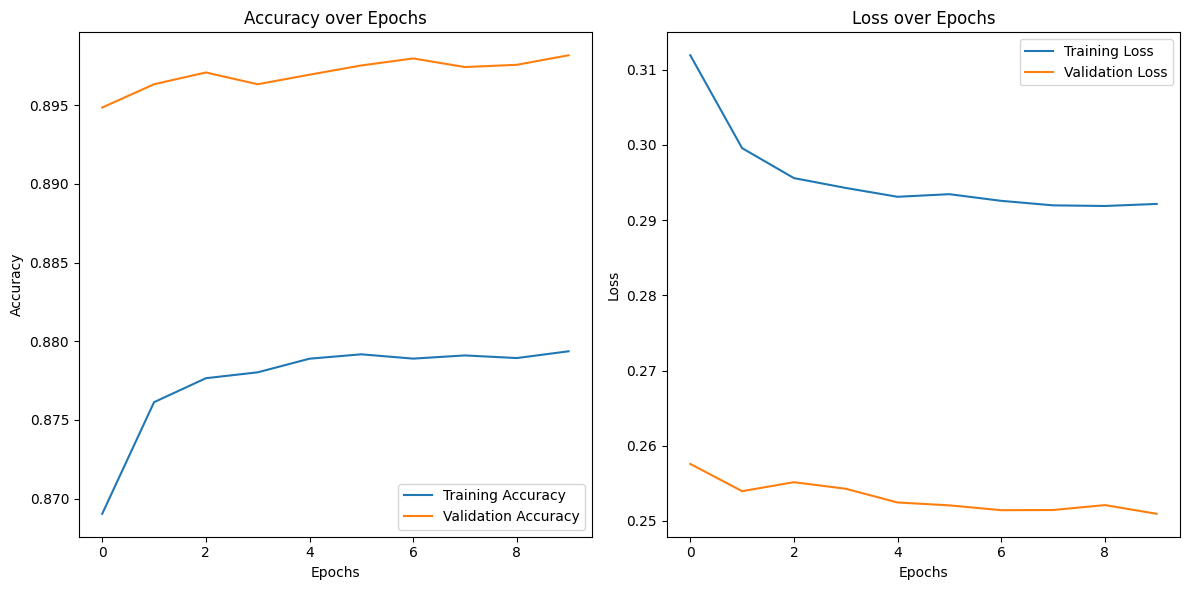

In [15]:
# Step 8: Plot Accuracy and Loss over Epochs
# Initialize lists to store the accuracy and loss for all folds
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Find the minimum number of epochs across all folds
min_epochs = min([len(fold_history['accuracy']) for fold_history in history])

# Collect history for each fold and trim to the minimum number of epochs
for fold_history in history:
    train_accuracies.append(fold_history['accuracy'][:min_epochs])
    val_accuracies.append(fold_history['val_accuracy'][:min_epochs])
    train_losses.append(fold_history['loss'][:min_epochs])
    val_losses.append(fold_history['val_loss'][:min_epochs])

# Convert lists to numpy arrays and calculate average across folds
avg_train_accuracy = np.mean(train_accuracies, axis=0)
avg_val_accuracy = np.mean(val_accuracies, axis=0)
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(avg_train_accuracy, label='Training Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Step 8: Evaluate Model on Test Data
y_pred_prob_nn = model.predict(X_test_scaled)
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("\nNeural Network Accuracy:", accuracy_nn)
print("\nNeural Network Classification Report:\n", classification_report(y_test, y_pred_nn))

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Neural Network Accuracy: 0.8874048891047434

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      6177
           1       0.89      0.88      0.89      6177

    accuracy                           0.89     12354
   macro avg       0.89      0.89      0.89     12354
weighted avg       0.89      0.89      0.89     12354



In [17]:
# Step 9: ROC Curve and AUC for Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_prob_nn)
roc_auc_nn = roc_auc_score(y_test, y_pred_prob_nn)

# Step 10: Precision-Recall Curve and AUC-PR for Neural Network
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_prob_nn)
average_precision_nn = average_precision_score(y_test, y_pred_prob_nn)

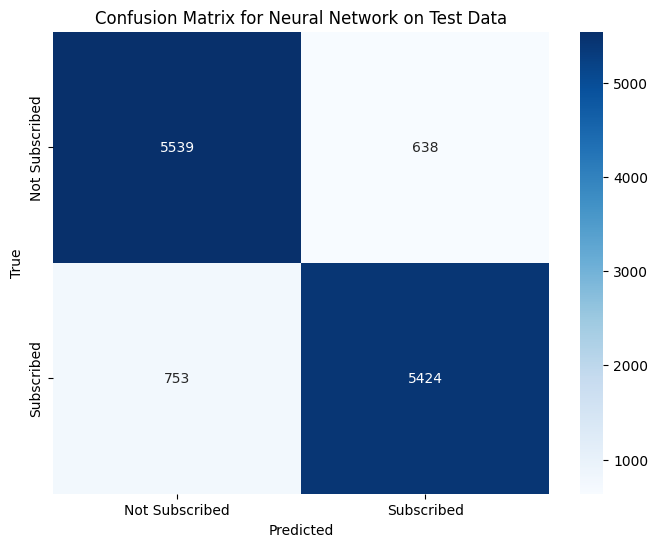

In [21]:
# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Not Subscribed', 'Subscribed'],
            yticklabels=['Not Subscribed', 'Subscribed'])
plt.title('Confusion Matrix for Neural Network on Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Training the Random Forest Model**

In [22]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print("Random Forest Cross-Validation Accuracy Scores:", cv_scores_rf)
print("Mean Random Forest Cross-Validation Accuracy:", np.mean(cv_scores_rf))
print("Standard Deviation of Random Forest Cross-Validation Accuracy:", np.std(cv_scores_rf))


Random Forest Cross-Validation Accuracy Scores: [0.9200259  0.91945276 0.92803368 0.92244799 0.919048  ]
Mean Random Forest Cross-Validation Accuracy: 0.9218016671917342
Standard Deviation of Random Forest Cross-Validation Accuracy: 0.0033319365878143933


In [23]:
# Train RF Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model (Random Forest)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9207544115266311

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      6186
           1       0.93      0.91      0.92      6168

    accuracy                           0.92     12354
   macro avg       0.92      0.92      0.92     12354
weighted avg       0.92      0.92      0.92     12354



In [24]:
# Step 9: Predict on Test Data for Random Forest
y_pred_rf_prob = rf_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

# Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_prob)
average_precision_rf = average_precision_score(y_test, y_pred_rf_prob)

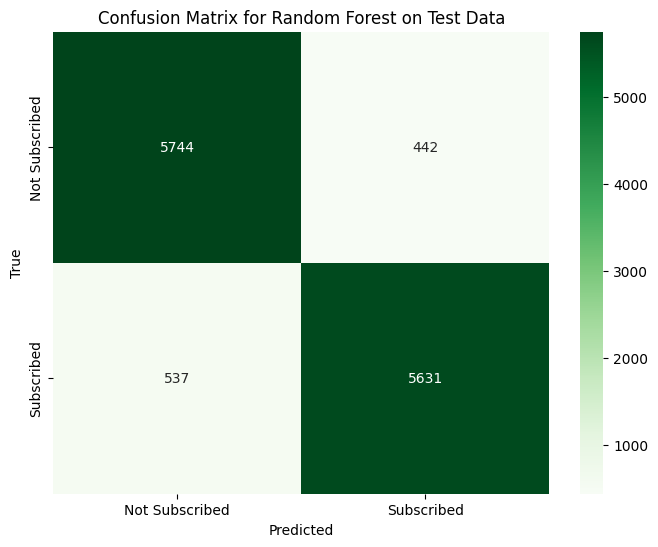

In [25]:
# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Greens',  # Change the color scheme to green
    xticklabels=['Not Subscribed', 'Subscribed'],
    yticklabels=['Not Subscribed', 'Subscribed']
)
plt.title('Confusion Matrix for Random Forest on Test Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# **ROC Curves for Both Models**

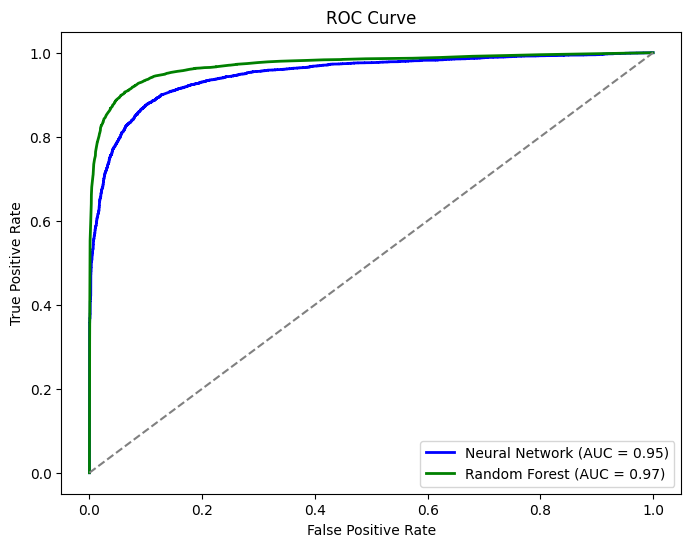

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random chance
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# **Precision-Recall Curves for Both Models**

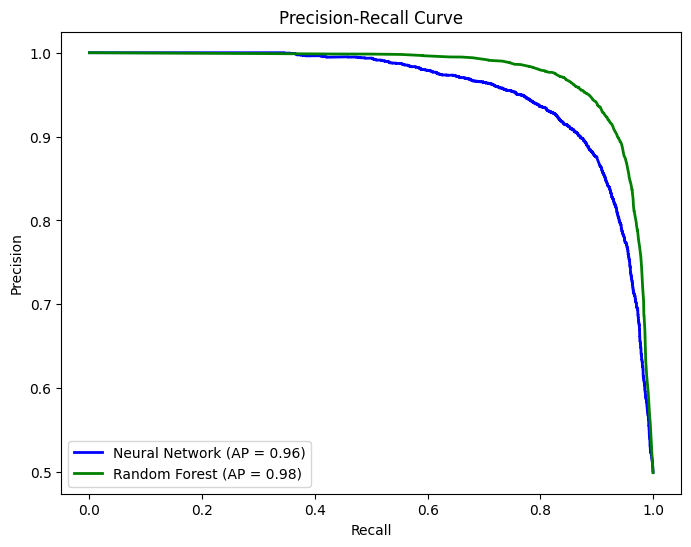

In [28]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_nn, precision_nn, color='blue', lw=2, label=f'Neural Network (AP = {average_precision_nn:.2f})')
plt.plot(recall_rf, precision_rf, color='green', lw=2, label=f'Random Forest (AP = {average_precision_rf:.2f})')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()